## Lecture 6 - Generating hep-ph titles with Transformers 

> Too lazy to think of a catchy title for your next paper? Then this lecture is for you!

## Learning objectives

* Gain hands-on experience using the Hugging Face Transformers library
* Understand how to prepare and tokenizer a text dataset for Transformer models
* Learn how to fine-tune a Transformer for text summarization and how to evaluate it's performance

Understanding the main steps involved in fine-tuning Transformers for NLP, will put you in good stead to understand advanced particle physics applications such as the [Particle Transformer](https://arxiv.org/abs/2202.03772).

## References

* Chapter 6 of [_Natural Language Processing with Transformers_](https://transformersbook.com/) by L. Tunstall, L. von Werra, and T. Wolf
* [_On the Use of ArXiv as a Dataset_](https://arxiv.org/abs/1905.00075) by C. Clement et al.

## Setup

In [ ]:
# Uncomment and run this cell if using Colab, Kaggle etc
# %pip install transformers datasets evaluate rouge_score nltk

To be able to share your model with the community there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up here if you haven't already!) then execute the following cell and input your username and password:

In [ ]:
notebook_login()

Then you need to install Git-LFS. Uncomment and execute the following cell:

In [ ]:
# !apt install git-lfs

## Imports

In [2]:
import nltk
import numpy as np
from datasets import load_dataset
from evaluate import load
from huggingface_hub import notebook_login
from IPython.display import YouTubeVideo
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    pipeline,
)

In [3]:
import datasets

# Suppress logs to keep things tidy
datasets.logging.set_verbosity_error()
# Download special package for computing metrics
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/lewis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Loading the data

Until now, we've been using the Top Tagging Dataset to explore various neural network architectures, from MLPs to CNNs. Today we'll do something completely different and explore an application of Transformers to a natural language processing (NLP) task called _text summarization_! As the name suggests, text summarization involves condensing long documents into crips summaries. To give the task a physics flavour, we'll use a dump of arXiv hep-ph papers and train a model to summarise the abstract into a title. This way, the next time you're lacking inspiration on your next big paper, you can just get the model to cook it up for you!

To get started, we'll need a dataset of arXiv papers. Fortunately, someone from the community has uploaded a dump of papers to the Hugging Face Hub, so we can download it using the familiar `load_dataset()` function:

In [4]:
raw_dataset = load_dataset("gfissore/arxiv-abstracts-2021", split="train")
raw_dataset

Dataset({
    features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'abstract', 'report-no', 'categories', 'versions'],
    num_rows: 1999486
})

Okay, this is quite a lot of papers! Let's take a look at one example:

In [5]:
raw_dataset[0]

{'id': '0704.0001',
 'submitter': 'Pavel Nadolsky',
 'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
 'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
 'comments': '37 pages, 15 figures; published version',
 'journal-ref': 'Phys.Rev.D76:013009,2007',
 'doi': '10.1103/PhysRevD.76.013009',
 'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with data from the Fermilab Tevatron, and predictions are made for\nmore detailed tests with C

We can see that each example consists of an `abstract` and `title`, along with various metadata about the submission. To keep things focused, let's filter the dataset for just those papers which have a `hep-ph` category. To do so, we can use the `filter()` method in the `datasets` library. This method applies a boolean function to every row in the dataset, and removes rows where the function evaluates to false. In our case, we're interested in the `categories` column, so let's check how many hep-ph papers we have:

In [6]:
category = "hep-ph"
hep_dataset = raw_dataset.filter(lambda x: category in x["categories"])
hep_dataset

Dataset({
    features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'abstract', 'report-no', 'categories', 'versions'],
    num_rows: 76022
})

Great, this is a much more manageable dataset to work with! As a sanity check, you can pick your name or that of a colleague to see if any relevant papers are found in the corpus:

In [7]:
author = "tunstall"
sample_dataset = hep_dataset.filter(lambda x: "tunstall" in x["authors"].lower())
for row in sample_dataset:
    print(f"Title: {row['title']} \n")
    print(f"Authors: {row['authors']} \n")
    print(f"Abstract: {row['abstract']}")
    print("=" * 50, "\n")

Title: Infrared Fixed Point in the Strong Running Coupling: Unraveling the
  \Delta I=1/2 puzzle in K-Decays 

Authors: R.J. Crewther and Lewis C. Tunstall 

Abstract:   In this talk, we present an explanation for the Delta I = 1/2 rule in
K-decays based on the premise of an infrared fixed point alpha_IR in the
running coupling alpha_s of quantum chromodynamics (QCD) for three light quarks
u,d,s. At the fixed point, the quark condensate spontaneously breaks scale and
chiral SU(3)_L x SU(3)_R symmetry. Consequently, the low-lying spectrum
contains nine Nambu-Goldstone bosons: pi,K,eta and a QCD dilaton sigma. We
identify sigma as the f_0(500) resonance and construct a chiral-scale
perturbation theory CHPT_sigma for low-energy amplitudes expanded in alpha_s
about alpha_IR. The Delta I = 1/2 rule emerges in the leading order of
CHPT_sigma through a sigma-pole term K_S --> sigma --> 2 pi, with a K_S-sigma
coupling fixed by data on 2 gamma --> 2 pi^0 and K_S --> 2 gamma. We also
determine R

These look like hep-ph papers, so now let's process the raw text in the abstracts and titles into a format that's suitable for neural networks!

## From text to tokens

Like other machine learning models, Transformers expect their inputs in the form of numbers (not strings) and so some form of preprocessing is required. For NLP, this preprocessing step is called tokenization. Tokenization converts strings into atomic chunks called tokens, and these tokens are subsequently encoded as numerical vectors.

For more information about tokenizers, check out the following video:

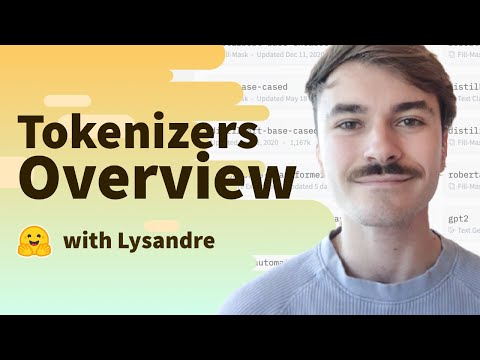

In [8]:
YouTubeVideo("VFp38yj8h3A", width=600, height=400)

Each pretrained model comes with its own tokenizer, so to get started let's download the tokenizer of a popular model called T5 from the Hub:

In [9]:
model_checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/home/lewis/miniconda3/envs/dl4phys/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


The tokenizer has a few interesting attributes such as the vocabulary size:

In [10]:
tokenizer.vocab_size

32100

This tells us that T5 has 32,100 tokens that is can use to represent text with. Some of the tokens are called special tokens to indicate whether a token is the start or end of a sentence, or corresponds to the mask that is associated with language modeling. 

When you feed strings to the tokenizer, you'll get at least two fields (some models have more, depending on how they're trained):

* `input_ids`: These correspond to the numerical encodings that map each token to an integer
* `attention_mask`: This indicates to the model which tokens should be ignored when computing self-attention

Let's see how this works with a simple example. First we encode the string:

In [12]:
encoded_str = tokenizer("Albert Einstein lived in Bern")
encoded_str

{'input_ids': [11375, 890, 4008, 4114, 16, 8942, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

and then decode the input IDs to see the mapping explicitly:

In [13]:
for token in encoded_str["input_ids"]:
    print(token, tokenizer.decode([token]))

11375 Albert
890 Ein
4008 stein
4114 lived
16 in
8942 Bern
1 </s>


So to prepare our inputs, we simply need to apply the tokenizer to each example in our corpus. The only subtlety is that our targets are the paper titles, and these are also strings! So, we'll also need to tokenize them as well. The following function takes care of both these preprocessing steps:

In [15]:
max_input_length = 1024  # Truncate abstracts longer than this
max_target_length = 128  # Truncate titles longer than this
prefix = "summarize: "  # A special feature of T5 to indicate which task to condition the model on


def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["abstract"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["title"], max_length=max_target_length, truncation=True
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

With this function we can tokenize the whole dataset with a `map()` operation:

In [18]:
tokenized_dataset = hep_dataset.map(
    preprocess_function, batched=True, remove_columns=hep_dataset.column_names
)

Now that we've tokenized our corpus, it's time to load a pretrained model!

## Loading a pretrained model

To load a pretrained model from the Hub is quite simple: just select the appropriate `AutoModelForXxx` class and use the `from_pretrained()` function with the model checkpoint. In our case, we're dealing with a sequence-to-sequence task (mapping abstracts to titles), so the corresponding autoclass is as follows:

In [28]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

These warnings are perfectly normal - they are telling us that the weights in the head of the network are randomly initialised and so we should fine-tune the model on a downstream task.

Now that we have a model, the next step is to initialise a `Trainer` that will take care of the training loop for us (similar to the `Learner` in fastai). Let's do that next.

## Creating a Trainer

To create a `Trainer`, we usually need a few basic ingredients:

* A `TrainingArguments` class to define all the hyperparameters
* A `compute_metrics()` function to compute metrics during evaluation
* Datasets to train and evaluate on

For more information about the `Trainer` check out the following video:

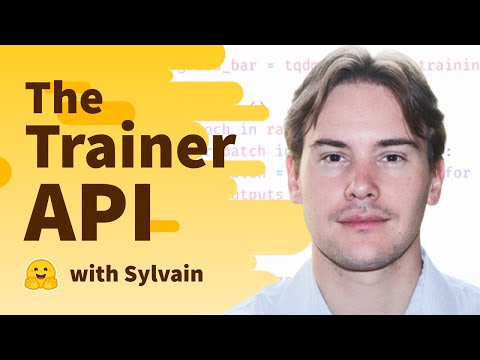

In [19]:
YouTubeVideo("nvBXf7s7vTI", width=600, height=400)

Let's start with the `TrainingArguments`:

In [29]:
batch_size = 16
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-arxiv",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_steps=2000,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=True,
)

Here we've defined output_dir to save our checkpoints and tweaked some of the default hyperparameters like the learning rate and weight decay. The push_to_hub argument will push each checkpoint to the Hub automatically for us, so we can reuse the model at any point in the future!

Now that we've defined the hyperparameters, the next step is to define the metrics. Measuring the performance of text generation tasks like summarization or translation is not as straightforward as classification/regression tasks. For example, given a review like “I loved reading the Hunger Games”, there are multiple valid summaries, like “I loved the Hunger Games” or “Hunger Games is a great read”. Clearly, applying some sort of exact match between the generated summary and the label is not a good solution — even humans would fare poorly under such a metric, because we all have our own writing style.

For summarization, one of the most commonly used metrics is the ROUGE score (short for Recall-Oriented Understudy for Gisting Evaluation). The basic idea behind this metric is to compare a generated summary against a set of reference summaries that are typically created by humans. If you want to learn more about this metric, check out the video below - for now it is enough to know that higher ROUGE scores are associated with "better" summaries.

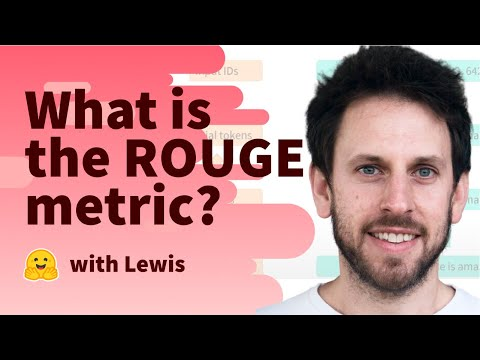

In [20]:
YouTubeVideo("TMshhnrEXlg", width=600, height=400)

To load a metric, we'll use the `evaluate` library which hosts a wide variety of metrics for machine learning. To load a metric is quite simple:

In [30]:
metric = load("rouge")

Couldn't find a directory or a metric named 'rouge' in this version. It was picked from the master branch on github instead.


And once we have a metric, we can now compute the ROUGE scores using the `compute()` function:

In [31]:
generated_summary = "I absolutely loved reading the Hunger Games"
reference_summary = "I loved reading the Hunger Games"
scores = metric.compute(predictions=[generated_summary], references=[reference_summary])
scores

{'rouge1': AggregateScore(low=Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923), mid=Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923), high=Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923)),
 'rouge2': AggregateScore(low=Score(precision=0.6666666666666666, recall=0.8, fmeasure=0.7272727272727272), mid=Score(precision=0.6666666666666666, recall=0.8, fmeasure=0.7272727272727272), high=Score(precision=0.6666666666666666, recall=0.8, fmeasure=0.7272727272727272)),
 'rougeL': AggregateScore(low=Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923), mid=Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923), high=Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923)),
 'rougeLsum': AggregateScore(low=Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923), mid=Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.92307692307

Whoa, there’s a lot of information in that output — what does it all mean? First, `evaluate` actually computes confidence intervals for precision, recall, and F1-score; these are the low, mid, and high attributes you can see here. Moreover, `evaluate` computes a variety of ROUGE scores which are based on different types of text granularity when comparing the generated and reference summaries. The rouge1 variant is the overlap of unigrams — this is just a fancy way of saying the overlap of words and is exactly the metric we’ve discussed above. To verify this, let’s pull out the mid value of our scores:

In [32]:
scores["rouge1"].mid

Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923)

Now what about those other ROUGE scores? rouge2 measures the overlap between bigrams (think the overlap of pairs of words), while rougeL and rougeLsum measure the longest matching sequences of words by looking for the longest common substrings in the generated and reference summaries. The “sum” in rougeLsum refers to the fact that this metric is computed over a whole summary, while rougeL is computed as the average over individual sentences.

Next, let's define the `compute_metrics()` function that we'll use to evaluate our model. For summarization this is a bit more involved than simply calling `metric.compute()` on the model’s predictions, since we need to decode the outputs and labels into text before we can compute the ROUGE scores. The following function does exactly that, and also makes use of the `sent_tokenize()` function from nltk to separate the summary sentences with newlines:

In [33]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = [
        "\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds
    ]
    decoded_labels = [
        "\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels
    ]

    result = metric.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

    # Add mean generated length
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions
    ]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

Next, we need to define a data collator for our sequence-to-sequence task. Since T5 is an encoder-decoder Transformer model, one subtlety with preparing our batches is that during decoding we need to shift the labels to the right by one. This is required to ensure that the decoder only sees the previous ground truth labels and not the current or future ones, which would be easy for the model to memorize. This is similar to how masked self-attention is applied to the inputs in a task like causal language modeling.

Luckily, 🤗 Transformers provides a `DataCollatorForSeq2Seq` collator that will dynamically pad the inputs and the labels for us. To instantiate this collator, we simply need to provide the tokenizer and model:

In [34]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

We finally have all the ingredients we need to train with! We now simply need to create a train and test split and instantiate the trainer with the standard arguments:

In [37]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [38]:
tokenized_datasets = tokenized_dataset.train_test_split(seed=42)

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

The only thing left to do is launch our training run:

In [21]:
trainer.train();

/home/lewis/miniconda3/envs/dl4phys/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 57016
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3564


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.382500,2.155587,37.851500,20.438100,34.011400,34.004200,15.821400


Saving model checkpoint to t5-small-finetuned-arxiv/checkpoint-2000
Configuration saved in t5-small-finetuned-arxiv/checkpoint-2000/config.json
Model weights saved in t5-small-finetuned-arxiv/checkpoint-2000/pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-arxiv/checkpoint-2000/tokenizer_config.json
Special tokens file saved in t5-small-finetuned-arxiv/checkpoint-2000/special_tokens_map.json
tokenizer config file saved in t5-small-finetuned-arxiv/tokenizer_config.json
Special tokens file saved in t5-small-finetuned-arxiv/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 19006
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=3564, training_loss=2.4908802747458854, metrics={'train_runtime': 619.9777, 'train_samples_per_second': 91.965, 'train_steps_per_second': 5.749, 'total_flos': 6193120296566784.0, 'train_loss': 2.4908802747458854, 'epoch': 1.0})

The final thing to do is push the model weights to the Hub, as follows:

In [ ]:
trainer.push_to_hub()

## Using your fine-tuned model

Now that we've pushed our model to the Hub, let's see how it fares on some abstracts that it's never seen before! First, we'll load the model using the `pipeline()` function:

In [47]:
summarizer = pipeline("summarization", model="lewtun/t5-small-finetuned-arxiv")

And then we can feed it an abstract to summarise:

In [48]:
# from https://arxiv.org/abs/2206.00678
abstract = """We demonstrate that the observed cosmological excess of matter over antimatter
may originate from a heavy QCD axion that solves the strong CP problem but has a
mass much larger than that given by the Standard Model QCD strong dynamics. We
investigate a rotation of the heavy QCD axion in field space, which is
transferred into a baryon asymmetry through weak and strong sphaleron processes.
This provides a strong cosmological motivation for heavy QCD axions, which are
of high experimental interest. The viable parameter space has an axion mass ma
between 1~MeV and 10 GeV and a decay constant fa<105 GeV, which can be probed by
accelerator-based direct axion searches and observations of the cosmic microwave
background."""

summarizer(abstract)

Your max_length is set to 200, but you input_length is only 177. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


[{'summary_text': 'Heavy QCD axions in a baryon asymmetry through weak and strong sphaleron processes and a decay constant fa105 GeV'}]

The original title is _Axiogenesis with a Heavy QCD Axion_, so our model has done a pretty good job!

## Exercises

* Try fine-tuning the model on a different arXiv category like hep-lat. Do the generated titles still make sense?